In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.datasets import  mnist

In [4]:
(X_train,y_train),(X_test,y_test)=mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


# Reshaping the data

In [10]:
X_train=X_train/255

GAN will use tanh function in the last layer so we need the values of X_train between -1  and 1

In [12]:
X_train.shape

(60000, 28, 28)

In [13]:
X_train=X_train.reshape(-1,28,28,1)*2-1

In [14]:
X_train.min()

-1.0

In [15]:
X_train.max()

1.0

In [16]:
only_zeros=X_train[y_train==0]

In [17]:
only_zeros.shape

(5923, 28, 28, 1)

# Model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,LeakyReLU,Dropout,Conv2D,Conv2DTranspose,BatchNormalization,Reshape

In [22]:
import tensorflow as tf


In [23]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size=100

In [24]:
generator=Sequential()
generator.add(Dense(7*7*128,input_shape=[codings_size]))
generator.add(Reshape([7,7,128]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64,activation='relu',kernel_size=5,strides=2,padding='same'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(1,kernel_size=5,activation='tanh',padding='same',strides=2))


In [25]:
discriminator=Sequential()
discriminator.add(Conv2D(64,input_shape=[28,28,1],activation=LeakyReLU(0.3),padding='same',
                         strides=2,kernel_size=5))
discriminator.add(Dropout(0.5))
discriminator.add(Conv2D(128,padding='same',kernel_size=5,strides=2,activation=LeakyReLU(0.3),
                         ))
discriminator.add(Dropout(0.5))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [26]:
GAN=Sequential([generator,discriminator])

In [27]:
discriminator.compile(loss='binary_crossentropy',optimizer='adam')
discriminator.trainable=False

In [28]:
GAN.compile(loss='binary_crossentropy',optimizer='adam')

In [29]:
GAN.layers

In [30]:
GAN.layers[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

In [31]:
GAN.layers[1].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 0
Non-trainabl

# Making Batches

In [32]:
batch_size=32

In [33]:
my_data=only_zeros

In [34]:
dataset=tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

In [35]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [36]:
dataset=dataset.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)

In [37]:
epochs=20

# Training

In [39]:
from numpy.core.fromnumeric import shape
from tensorflow.python.ops.gen_batch_ops import batch
generator,discriminator=GAN.layers

for epoch in range(epochs):
  print(f"Currently on epoch {epoch+1}")
  i=0
  for X_batch in dataset:
    i=i+1
    
    if i%20==0:
      print(f"Currently on batch {i} of {len(my_data)/batch_size}")


    noise=tf.random.normal(shape=[batch_size,codings_size])
    gen_images=generator(noise) 
    X_fake_vs_real=tf.concat([gen_images,tf.dtypes.cast(X_batch,tf.float32)],axis=0)
    y1=tf.constant([[0.0]]*batch_size+[[1.0]]*batch_size)
    discriminator.trainable=True

    discriminator.train_on_batch(X_fake_vs_real,y1)


    noise=tf.random.normal(shape=[batch_size,codings_size])
    y2=tf.constant([[1.0]]*batch_size)
    discriminator.trainable=False
    GAN.train_on_batch(noise,y2)


Currently on epoch 1
Currently on batch 20 of 185.09375
Currently on batch 40 of 185.09375
Currently on batch 60 of 185.09375
Currently on batch 80 of 185.09375
Currently on batch 100 of 185.09375
Currently on batch 120 of 185.09375
Currently on batch 140 of 185.09375
Currently on batch 160 of 185.09375
Currently on batch 180 of 185.09375
Currently on epoch 2
Currently on batch 20 of 185.09375
Currently on batch 40 of 185.09375
Currently on batch 60 of 185.09375
Currently on batch 80 of 185.09375
Currently on batch 100 of 185.09375
Currently on batch 120 of 185.09375
Currently on batch 140 of 185.09375
Currently on batch 160 of 185.09375
Currently on batch 180 of 185.09375
Currently on epoch 3
Currently on batch 20 of 185.09375
Currently on batch 40 of 185.09375
Currently on batch 60 of 185.09375
Currently on batch 80 of 185.09375
Currently on batch 100 of 185.09375
Currently on batch 120 of 185.09375
Currently on batch 140 of 185.09375
Currently on batch 160 of 185.09375
Currently on 

In [40]:
noise=tf.random.normal(shape=[10,codings_size])

In [41]:
noise.shape

TensorShape([10, 100])

In [42]:
images=generator(noise)

In [46]:
single_image=images[0]

In [47]:
single_image

<tf.Tensor: shape=(28, 28, 1), dtype=float32, numpy=
array([[[-0.9271307 ],
        [-0.9887961 ],
        [-0.9868991 ],
        [-0.9945041 ],
        [-0.9951267 ],
        [-0.9977584 ],
        [-0.9919989 ],
        [-0.99413615],
        [-0.97878337],
        [-0.9948405 ],
        [-0.99319375],
        [-0.9988645 ],
        [-0.996593  ],
        [-0.99902755],
        [-0.99846596],
        [-0.9998064 ],
        [-0.9998589 ],
        [-0.9999937 ],
        [-0.99994725],
        [-0.9999812 ],
        [-0.9998026 ],
        [-0.9997436 ],
        [-0.9966809 ],
        [-0.9987758 ],
        [-0.997526  ],
        [-0.99967474],
        [-0.9959728 ],
        [-0.9941177 ]],

       [[-0.98751336],
        [-0.9995476 ],
        [-0.9995934 ],
        [-0.9995585 ],
        [-0.9993442 ],
        [-0.99929595],
        [-0.9994992 ],
        [-0.999773  ],
        [-0.99921334],
        [-0.9994869 ],
        [-0.99979174],
        [-0.9999441 ],
        [-0.9998366 ],
  

In [50]:
single_image=single_image.numpy().reshape(28,28)

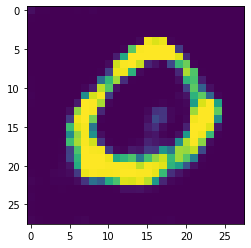

In [51]:
plt.imshow(single_image)

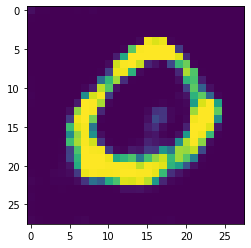

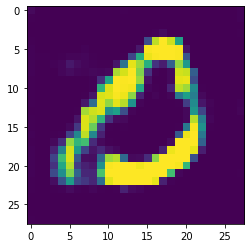

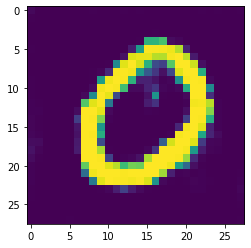

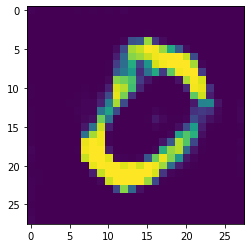

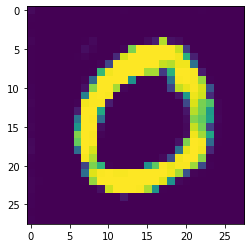

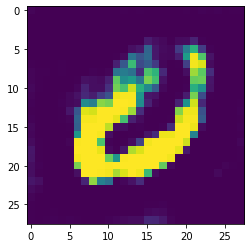

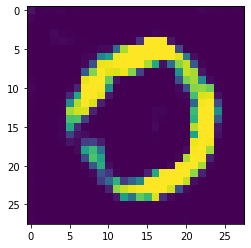

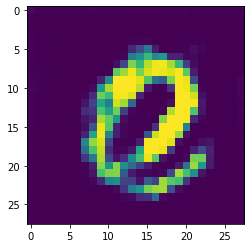

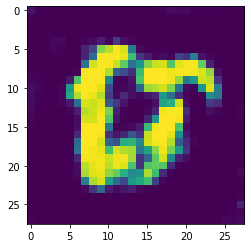

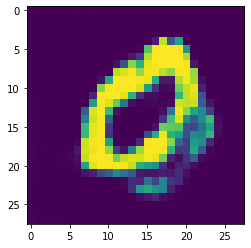

In [53]:
for image in images:
  plt.imshow(image.numpy().reshape(28,28))
  plt.show()

**The generator is able to produce adequate results just by noise**<br>
**We can easily identify that the produced images are of the number 0**